In [1]:
%matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
             
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [2]:
# Reload PandemiXModelFunctions, in case changes have been made
import importlib 
importlib.reload(pmf)

<module 'PandemiXModelFunctions' from 'c:\\Users\\rakrpe\\GithubRepos\\PandemiX\\modelling\\PandemiXModelFunctions.py'>

In [3]:
path_figs = os.getcwd() + '/Figures/'
path_figs = path_figs + 'TwoStrainModel_' 
path_dash = os.getcwd() + '/DanskeData/ssi_dashboard/'

# Load data

In [4]:

df = pd.read_csv('OmikronDeltaData.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Cut off everything before 2021-10-01
df = df[df.Date >= np.datetime64('2021-10-01')]
# df = df[df.Date >= np.datetime64('2021-09-15')]
df = df.reset_index()
df

,index,Date,Total,Delta,Omikron,Reinfections
0,273,2021-10-01,401,4.010000e+02,0.0,7
1,274,2021-10-02,325,3.250000e+02,0.0,2
2,275,2021-10-03,409,4.090000e+02,0.0,5
3,276,2021-10-04,552,5.520000e+02,0.0,6
4,277,2021-10-05,566,5.660000e+02,0.0,8
...,...,...,...,...,...,...
145,418,2022-02-23,23392,5.194067e-12,23392.0,1352
146,419,2022-02-24,20592,4.572343e-12,20592.0,1097
147,420,2022-02-25,16585,0.000000e+00,16585.0,889
148,421,2022-02-26,13839,0.000000e+00,13839.0,736


In [5]:

DateRestrictions = np.where(df.Date == np.datetime64('2021-12-15'))[0][0]
DateNewYears = np.where(df.Date == np.datetime64('2022-01-01'))[0][0]
DateRestrictionsEnd = np.where(df.Date == np.datetime64('2022-01-15'))[0][0]



In [6]:
# gamma = 1/4.7 

# plt.figure()
# plt.plot(pf.rnTime(df.Date,7),pf.rnMean(df.Delta/gamma,7))
# plt.plot(pf.rnTime(df.Date,7),pf.rnMean(df.Omikron/gamma,7))

# Define default model

In [7]:
# Initialize everything
DarkNumberRatio = 1.5
DKpop = 5800000

# Numbers for weeks 44, i.e. 2021-11-01
numVacc = 4423398
DKpop = 5889508
# preInf = 2219
preInf = 391219

# iniInf = DarkNumberRatio * df.Total[0:5].sum()/DKpop
iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:4]).sum()/DKpop
# iniVacc = 0.7 # Approximately DK's vaccinationsrate at the end of summer 2021
iniVacc = numVacc/DKpop 
# iniImmu = 0.05 # Approximation. Should only be "natural immunity"
iniImmu = DarkNumberRatio * (preInf/DKpop)
# iniImmu = 0.10 # Approximation. Should only be "natural immunity"
iniImmu = iniImmu * (1-iniVacc) # For splitting previous infections between vaccinated and susceptible

# iniVacc = iniVacc * 0.95 # Assuming approximately 5% of vaccinations didn't provide immunity
iniVacc = iniVacc * 0.925 # Assuming approximately 7.5% of vaccinations didn't provide immunity

V_0 = iniVacc 
IS_0 = 0
IV_0 = 0
Y_0 = iniInf
R01_0 = iniImmu
R10_0 = 0
I01_0 = 0
Y10_0 = 0
S_0 = 1 - V_0 - IS_0 - IV_0 - Y_0 - R01_0 - R10_0 - I01_0 - Y10_0 

init = {'S' : S_0,'V' : V_0,'IS' : IS_0,'IV' : IV_0,'Y' : Y_0,'R01' : R01_0,'R10' : R10_0,'I01' : I01_0,'Y10' : Y10_0}

# gammas = 1/7
gammas = 1/4.7
# gammas = 1/(5.5)
# gammas = 1/(2)
beta_Y = 4.1*gammas
beta_Y = 4.5*gammas
# beta_Y = 6.5*gammas
# beta_Y = 6.9*gammas
# beta_Y = 7.2*gammas
beta_I = 2*gammas
# beta_I = 1.5*gammas

pars = {'beta_IS_S' : beta_I,'beta_IV_S' : beta_I,'beta_I01_S' : beta_I,'beta_IS_V' : beta_I,'beta_IV_V' : beta_I,'beta_I01_V' : beta_I,'beta_IS_R01' : beta_I,'beta_IV_R01' : beta_I,'beta_I01_R01' : beta_I,'beta_Y_S' : beta_Y,'beta_Y10_S' : beta_Y,'beta_Y_R10' : beta_Y,'beta_Y10_R10' : beta_Y,'gamma_IS' : gammas,'gamma_IV' : gammas,'gamma_Y' : gammas,'gamma_I01' : gammas,'gamma_Y10' : gammas}

numDaysToSim = len(df.Date)    
tEnd = numDaysToSim+20
sch1 = pmf.Scheme('OmikronDeltaFull',init,pars,3,tEnd,Changes=[])


# Get delta-growth correct

(0.0, 20000.0)

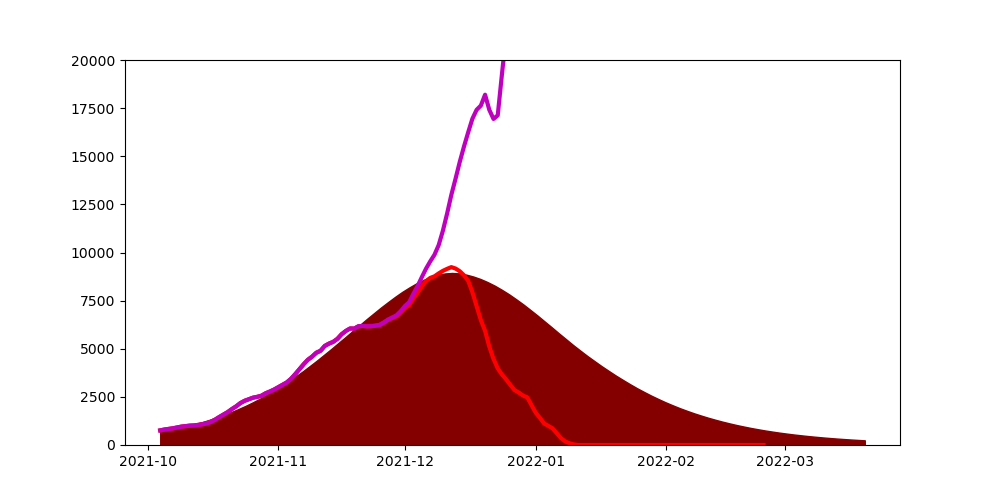

In [8]:
sch1.simulate()

curT = sch1.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

plt.figure(figsize=(10,5))
plt.fill_between(curDays,DKpop*sch1.result.Y*gammas,color='xkcd:dark red')
# plt.plot(pf.rnTime(df.Date,7),pf.rnMean(df.Delta/gammas,7))
plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)

plt.ylim(top=20000,bottom=0)

# Lockdown mid december

In [9]:
tLock = DateRestrictions
betaMult = 0.5
betaMult_Y_close = betaMult 
betaMult_I_close = betaMult 
betaMult_I_close = 0.6
dictToMult = {
'beta_IS_S' : betaMult_I_close,
'beta_IV_S' : betaMult_I_close,
'beta_I01_S' : betaMult_I_close,
'beta_IS_V' : betaMult_I_close,
'beta_IV_V' : betaMult_I_close,
'beta_I01_V' : betaMult_I_close,
'beta_IS_R01' : betaMult_I_close,
'beta_IV_R01' : betaMult_I_close,
'beta_I01_R01' : betaMult_I_close,
'beta_Y_S' : betaMult_Y_close,
'beta_Y10_S' : betaMult_Y_close,
'beta_Y_R10' : betaMult_Y_close,
'beta_Y10_R10' : betaMult_Y_close,
}
betaMultChange = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)

(0.0, 20000.0)

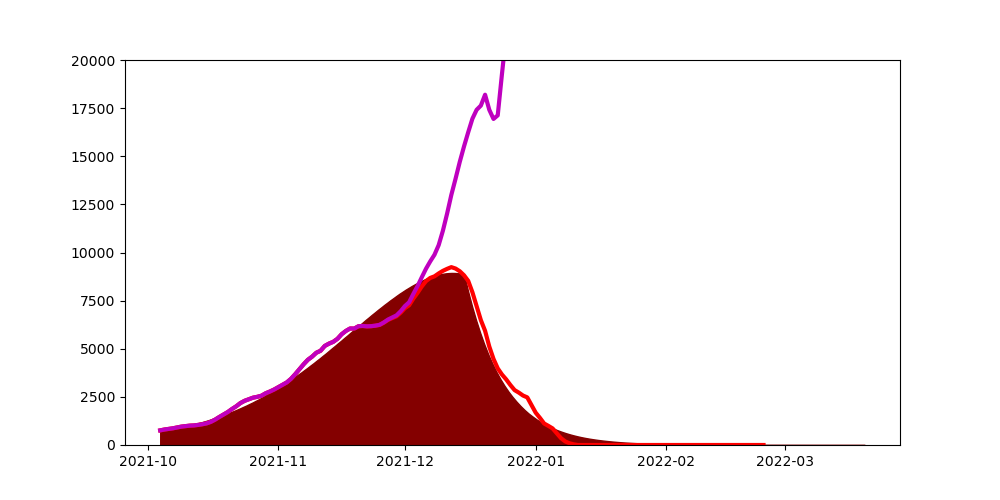

In [10]:
sch2.simulate()

curT = sch2.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

plt.figure(figsize=(10,5))
plt.fill_between(curDays,DKpop*sch2.result.Y*gammas,color='xkcd:dark red')
plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)

plt.ylim(top=20000,bottom=0)

In [11]:
tChange = 50
# tChange = 52
# tChange = 30
toAdd = iniInf/10
dictToAdd =  {  
    'S' : -toAdd,
    'IS' : toAdd,
}
addI = pmf.Change(tChange, AddVariables=dictToAdd)

tEnd = numDaysToSim+150
sch3 = pmf.Scheme('OmikronDeltaFull',init,pars,0,tEnd,Changes=[])
sch3.addChange(betaMultChange)
# sch2.addChange(betaMultChangeBack)

sch3.addChange(addI)
sch3.sortChanges()
sch3.simulate()

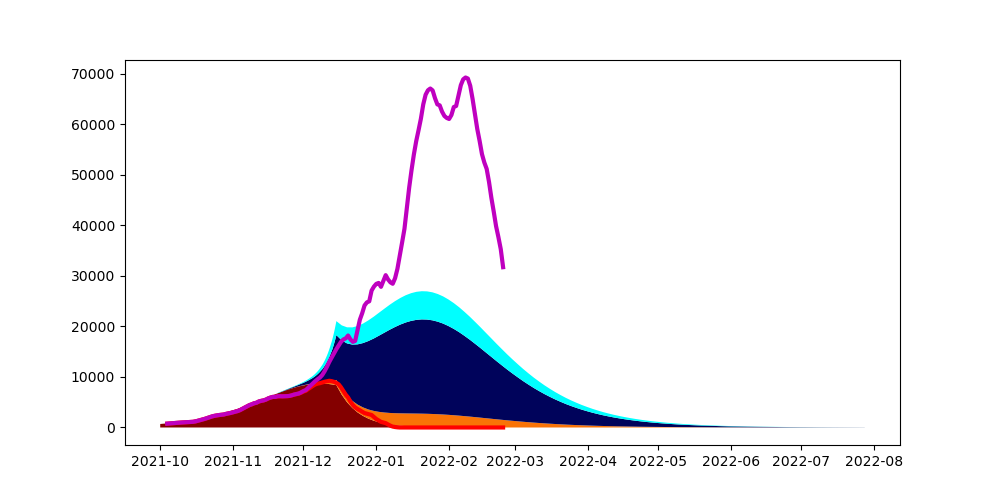

In [12]:
sch3.simulate()

curT = sch3.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

plt.figure(figsize=(10,5))
# plt.fill_between(curDays,DKpop*gammas*sch3.result.Y,color='xkcd:dark red')
plt.stackplot(curDays,
                DKpop*gammas*sch3.result.Y,
                DKpop*gammas*sch3.result.I01,
                DKpop*gammas*sch3.result.IV,
                DKpop*gammas*sch3.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# plt.fill_between(curDays,DKpop*gammas*sch3.result.IS,color='xkcd:dark blue')
# plt.fill_between(curDays,DKpop*gammas*sch3.result.IV,color='xkcd:cyan')
plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)

# plt.ylim(top=20000,bottom=0)

In [13]:
tOpen = DateNewYears + 7
# betaMult_Y = 1/betaMult_Y 
# betaMult_I = 1/betaMult_I 
betaMult_Y_newyear = 0.8/betaMult_Y_close 
betaMult_I_newyear = 0.8/betaMult_I_close 
dictToMult = {
'beta_IS_S' : betaMult_I_newyear,
'beta_IV_S' : betaMult_I_newyear,
'beta_I01_S' : betaMult_I_newyear,
'beta_IS_V' : betaMult_I_newyear,
'beta_IV_V' : betaMult_I_newyear,
'beta_I01_V' : betaMult_I_newyear,
'beta_IS_R01' : betaMult_I_newyear,
'beta_IV_R01' : betaMult_I_newyear,
'beta_I01_R01' : betaMult_I_newyear,
'beta_Y_S' : betaMult_Y_newyear,
'beta_Y10_S' : betaMult_Y_newyear,
'beta_Y_R10' : betaMult_Y_newyear,
'beta_Y10_R10' : betaMult_Y_newyear,
}
betaMultChangeNewYears = pmf.Change(tOpen, MultiplyParameters=dictToMult)

sch3 = pmf.Scheme('OmikronDeltaFull',init,pars,0,tEnd,Changes=[])
sch3.addChange(betaMultChange)
sch3.addChange(addI)
sch3.addChange(betaMultChangeNewYears)
sch3.sortChanges()
sch3.simulate()

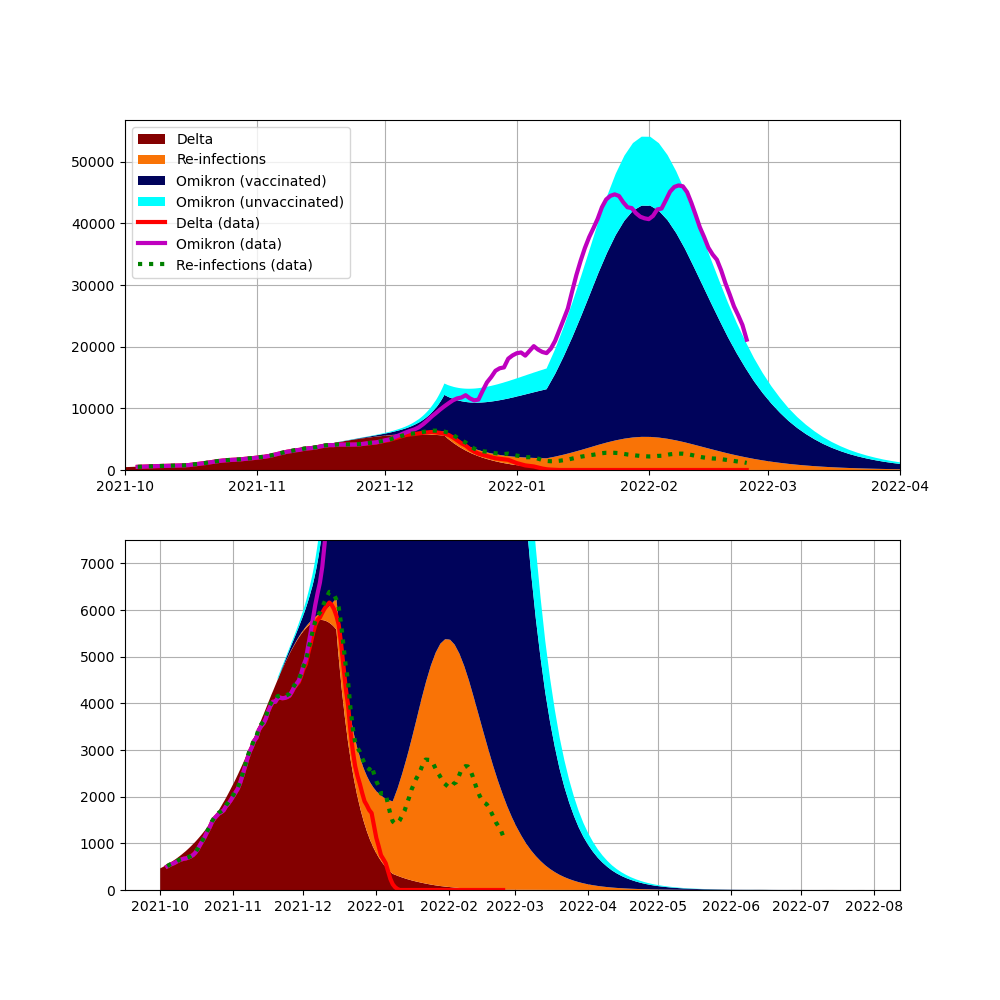

In [33]:
sch3.simulate()

curT = sch3.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
# plt.stackplot(curDays,
#                 DKpop*gammas*sch3.result.Y,
#                 DKpop*gammas*sch3.result.I01,
#                 DKpop*gammas*sch3.result.IV,
#                 DKpop*gammas*sch3.result.IS,
#                 colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
#                 labels=['Delta','Re-infections','Omikron (vaccinated)','Omikron (unvaccinated)']
#                 )
# plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3,label='Delta (data)')
# plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3,label='Omikron (data)')
# plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3,label='Re-infections (data)')


ax1.stackplot(curDays,
                DKpop*gammas*sch3.result.Y/DarkNumberRatio,
                DKpop*gammas*sch3.result.I01/DarkNumberRatio,
                DKpop*gammas*sch3.result.IV/DarkNumberRatio,
                DKpop*gammas*sch3.result.IS/DarkNumberRatio,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                labels=['Delta','Re-infections','Omikron (vaccinated)','Omikron (unvaccinated)']
                )
ax1.plot(pf.rnTime(df.Date,7), pf.rnMean(df.Delta,7),color='r',linewidth=3,label='Delta (data)')
ax1.plot(pf.rnTime(df.Date,7),( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3,label='Omikron (data)')
ax1.plot(pf.rnTime(df.Date,7),( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3,label='Re-infections (data)')

# plt.ylim(top=20000,bottom=0)
ax1.set_ylim(bottom=0)
ax1.grid()
ax1.set_axisbelow(True)

ax1.legend()
ax1.set_xlim(left=curDays[0],right=np.datetime64('2022-04-01'))

ax2.stackplot(curDays,
                DKpop*gammas*sch3.result.Y/DarkNumberRatio,
                DKpop*gammas*sch3.result.I01/DarkNumberRatio,
                DKpop*gammas*sch3.result.IV/DarkNumberRatio,
                DKpop*gammas*sch3.result.IS/DarkNumberRatio,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                labels=['Delta','Re-infections','Omikron (vaccinated)','Omikron (unvaccinated)']
                )
ax2.plot(pf.rnTime(df.Date,7), pf.rnMean(df.Delta,7),color='r',linewidth=3,label='Delta (data)')
ax2.plot(pf.rnTime(df.Date,7),( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3,label='Omikron (data)')
ax2.plot(pf.rnTime(df.Date,7),( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3,label='Re-infections (data)')

ax2.set_ylim(bottom=0,top=7500)
ax2.grid()
ax2.set_axisbelow(True)


plt.savefig('DeltaOmikronHandfit')

(18901.0, 19083.0)

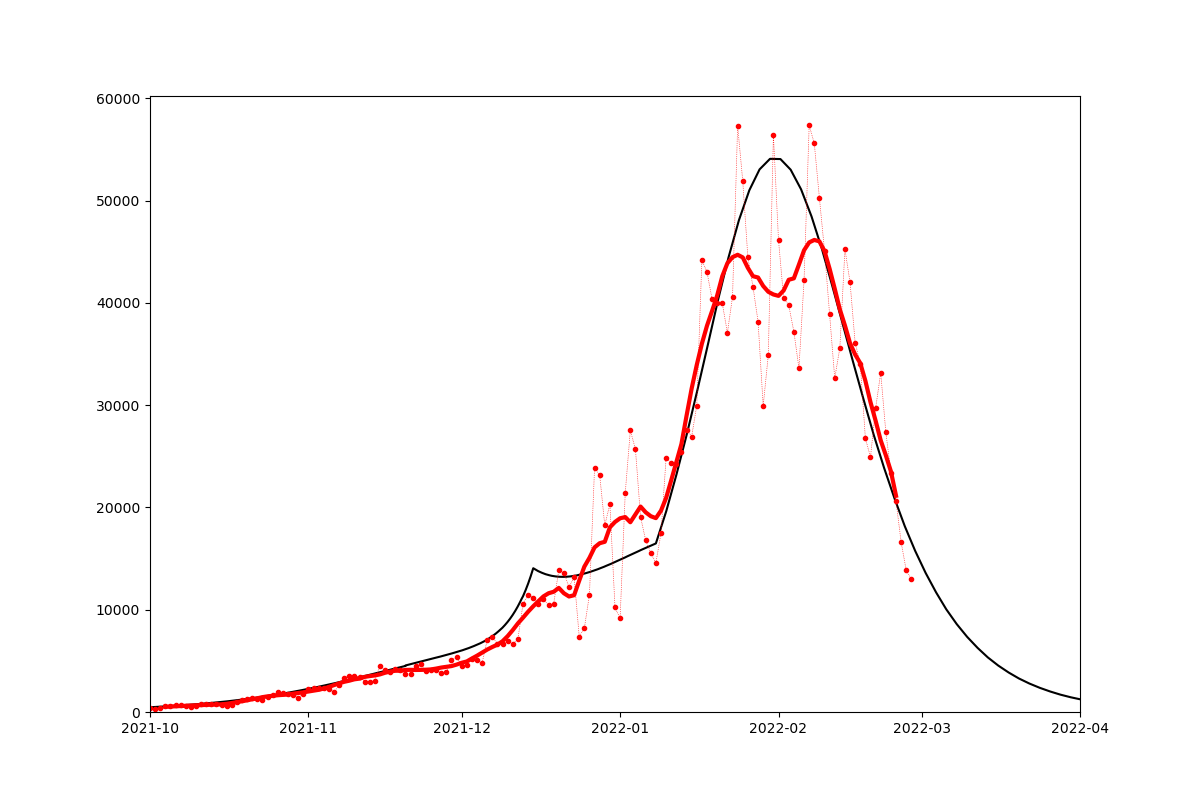

In [15]:
totInf = sch3.result.IV + sch3.result.IS + sch3.result.I01 + sch3.result.Y + sch3.result.Y10

plt.figure() 
# plt.plot(curDays,DKpop*gammas* totInf,'k')
# plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Total,7),color='r',linewidth=3)
# plt.plot(df.Date,DarkNumberRatio * df.Total,'.:',color='r',linewidth=0.5)
plt.plot(curDays,DKpop*gammas* totInf/DarkNumberRatio,'k')
plt.plot(pf.rnTime(df.Date,7),pf.rnMean(df.Total,7),color='r',linewidth=3)
plt.plot(df.Date,df.Total,'.:',color='r',linewidth=0.5)

plt.ylim(bottom=0)
plt.xlim(left=curDays[0],right=np.datetime64('2022-04-01'))
# plt.xlim(left=np.datetime64('2022-02-01'),right=np.datetime64('2022-04-01'))

# Later introduction of Delta

In [16]:
sch4 = sch3.copy() 
sch4.simulate()

In [17]:
tChange = 180
toAdd = iniInf/10
dictToAdd =  {  
    'S' : -toAdd,
    'Y' : toAdd,
}

parsToSet = {
    'beta_IS_S' : beta_I,
    'beta_IV_S' : beta_I,
    'beta_I01_S' : beta_I,
    'beta_IS_V' : beta_I,
    'beta_IV_V' : beta_I,
    'beta_I01_V' : beta_I,
    'beta_IS_R01' : beta_I,
    'beta_IV_R01' : beta_I,
    'beta_I01_R01' : beta_I,
    'beta_Y_S' : 6.0*gammas,
    'beta_Y10_S' : 6.0*gammas,
    'beta_Y_R10' : 6.0*gammas,
    'beta_Y10_R10' : 6.0*gammas,
}
addYAndSetDefault = pmf.Change(tChange, AddVariables=dictToAdd,SetParameters=parsToSet)

tEnd = numDaysToSim+300
# sch4 = pmf.Scheme('OmikronDeltaFull',init,pars,0,tEnd,Changes=[])
# sch4.addChange(betaMultChange)
# sch4.addChange(addI)
sch4 = sch3.copy()
sch4.tEnd = tEnd
sch4.addChange(addYAndSetDefault)
sch4.sortChanges()
sch4.simulate()

(18901.0, 19351.0)

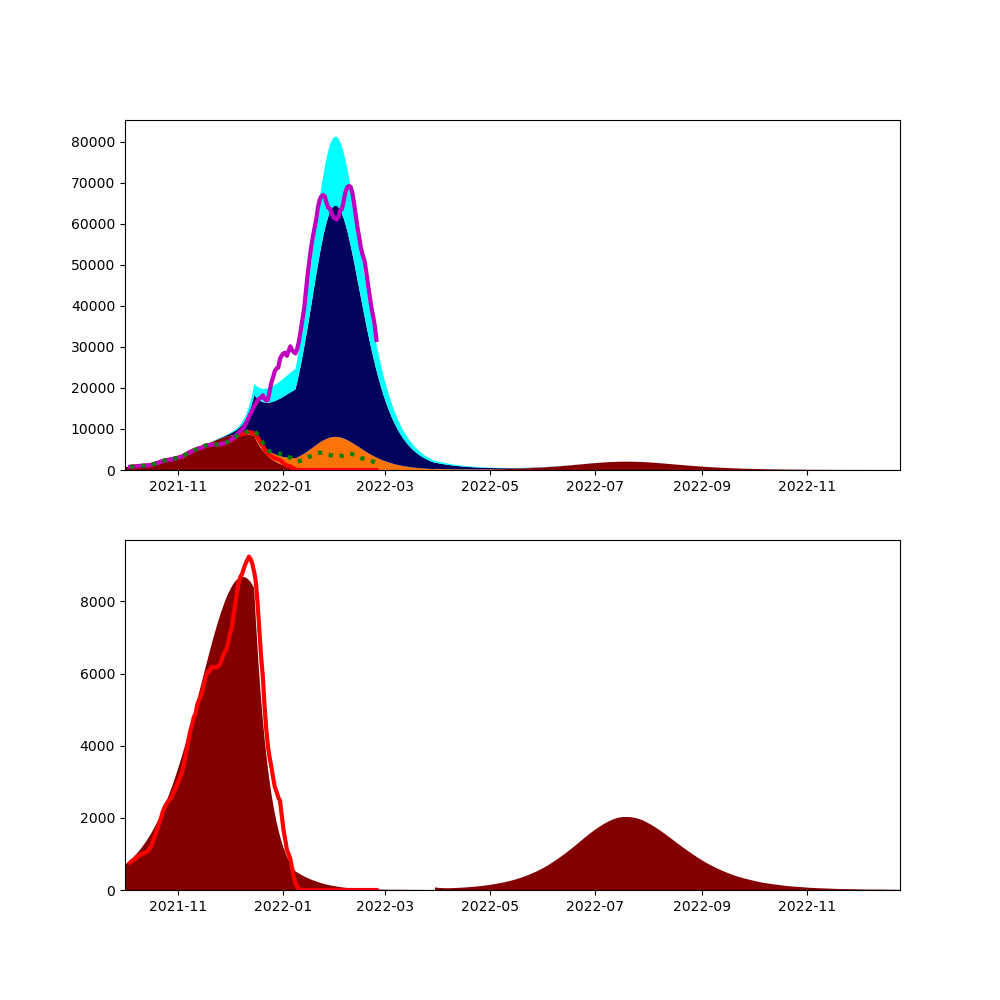

In [18]:
curSch = sch4
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))
fig,(ax1,ax2)= plt.subplots(2,1,figsize=(10,10))
# plt.fill_between(curDays,DKpop*gammas*curSch.result.Y,color='xkcd:dark red')
ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax2.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                colors=['xkcd:dark red'],
                )
ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
# ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
# ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

# plt.ylim(top=20000,bottom=0)
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=curDays[0],right=curDays[-1])
ax2.set_ylim(bottom=0)
ax2.set_xlim(left=curDays[0],right=curDays[-1])

# Hospitalizations 

In [19]:
# # Load data from "noegletal"
# # Until 2021-12-20, all dates were included in one file. Since then, additional data was added, and the file only contains the most recent numbers

# # latestsubdirs_dash = list(os.walk(path_dash))[0][1]
# # latestsubdirs_dash = 'SSI_dashboard_2021-12-17'
# lastFullFileIndex = np.where([x == 'SSI_dashboard_2021-12-17' for x in latestsubdirs_dash])[0][0]
# latestdir_dash = path_dash + latestsubdirs_dash[lastFullFileIndex]

# dfKey = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')

# dfKeysArray = []
# for k in range(lastFullFileIndex+1,len(latestsubdirs_dash)):
    
#     latestdir_dash = path_dash + latestsubdirs_dash[k]
#     curdf = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')
#     dfKeysArray.append(curdf)
    

# dfKey['IndberetningDato'] = pd.to_datetime(dfKey['IndberetningDato'])

# print(dfKey.columns)
# dfKey.tail()

In [20]:

u_H = 1/14
r_chr_IS = 0.05 
r_chr_IV = 0.005 
r_chr_Y = 0.05
r_chr_I01 = 0.0025 


ts = sch3.result.t
# Is = sch3.result.IS

k = 0
int_IS = cumtrapz(np.exp(u_H*ts)*sch3.result.IS,ts, initial=0)
int_IV = cumtrapz(np.exp(u_H*ts)*sch3.result.IV,ts, initial=0)
int_Y = cumtrapz(np.exp(u_H*ts)*sch3.result.Y,ts, initial=0)
int_I01 = cumtrapz(np.exp(u_H*ts)*sch3.result.I01,ts, initial=0)
Hs_IS = np.exp(-u_H*ts) * (r_chr_IS*gammas*int_IS + k) 
Hs_IV = np.exp(-u_H*ts) * (r_chr_IV*gammas*int_IV + k) 
Hs_Y = np.exp(-u_H*ts) * (r_chr_Y*gammas*int_Y + k) 
Hs_I01 = np.exp(-u_H*ts) * (r_chr_I01*gammas*int_I01 + k) 


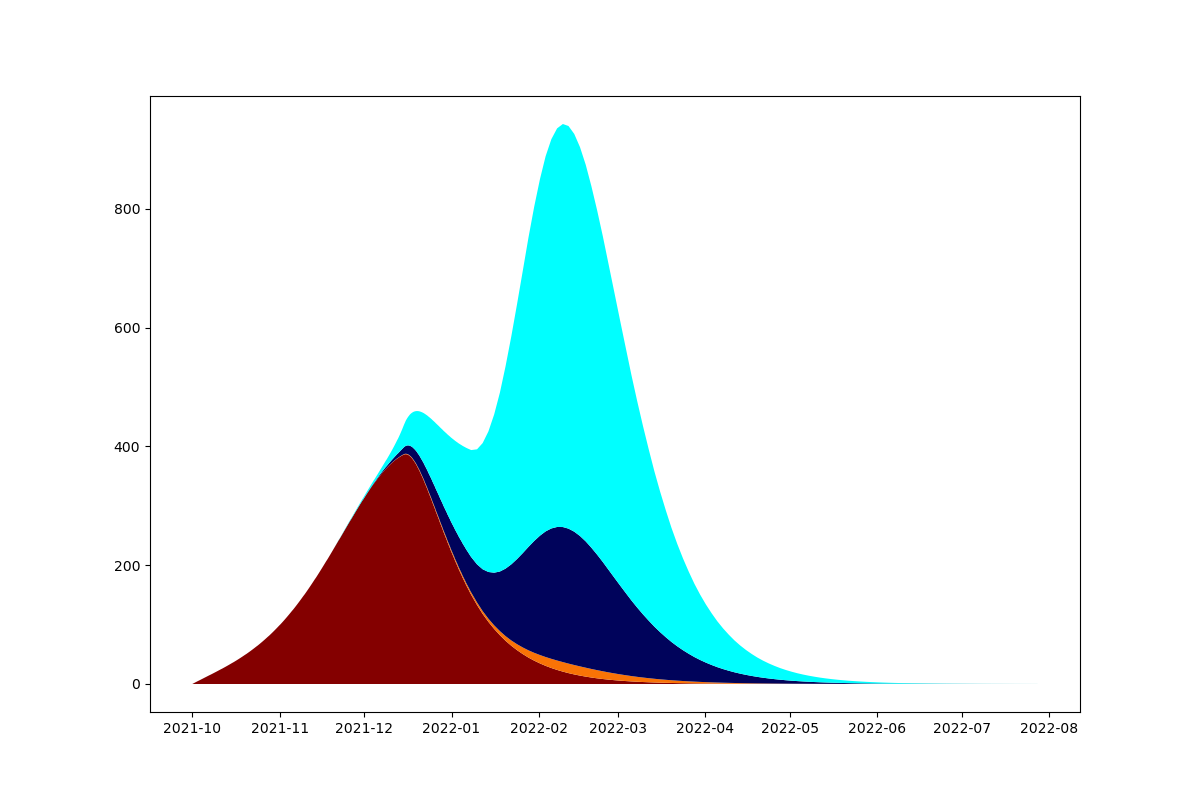

In [21]:

curT = sch3.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])
plt.figure() 
plt.stackplot(curDays,
            u_H*DKpop*Hs_Y,
            u_H*DKpop*Hs_I01,
            u_H*DKpop*Hs_IV,
            u_H*DKpop*Hs_IS,
            colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
)

# plt.plot(curDays,Hs_IS)
# plt.plot(curDays,Hs_IV)
# plt.plot(curDays,Hs_I01)
# plt.plot(curDays,Hs_Y)

# Old

In [22]:
# tLock = DateRestrictions + 7
# # betaMult_Y = 1/betaMult_Y 
# # betaMult_I = 1/betaMult_I 
# betaMult_Y = 0.7*1/betaMult_Y 
# betaMult_I = 0.7*1/betaMult_I 
# dictToMult = {
# 'beta_IS_S' : betaMult_I,
# 'beta_IV_S' : betaMult_I,
# 'beta_I01_S' : betaMult_I,
# 'beta_IS_V' : betaMult_I,
# 'beta_IV_V' : betaMult_I,
# 'beta_I01_V' : betaMult_I,
# 'beta_IS_R01' : betaMult_I,
# 'beta_IV_R01' : betaMult_I,
# 'beta_I01_R01' : betaMult_I,
# 'beta_Y_S' : betaMult_Y,
# 'beta_Y10_S' : betaMult_Y,
# 'beta_Y_R10' : betaMult_Y,
# 'beta_Y10_R10' : betaMult_Y,
# }
# betaMultChangeChristmas = pmf.Change(tLock, MultiplyParameters=dictToMult)

# sch3 = pmf.Scheme('OmikronDeltaFull',init,pars,0,tEnd,Changes=[])
# sch3.addChange(betaMultChange)
# sch3.addChange(addI)
# sch3.addChange(betaMultChangeChristmas)
# sch3.sortChanges()
# sch3.simulate()

In [23]:
# tLock = DateRestrictions + 7
# toAdd = 0.01
# dictToAdd = {
#     'S': -toAdd,
#     'IS' : toAdd/2,
#     'IV' : toAdd/2,
# }
# betaMultChangeChristmas = pmf.Change(tLock, AddVariables=dictToAdd)

# sch3 = pmf.Scheme('OmikronDeltaFull',init,pars,0,tEnd,Changes=[])
# sch3.addChange(betaMultChange)
# sch3.addChange(addI)
# sch3.addChange(betaMultChangeChristmas)
# sch3.sortChanges()
# sch3.simulate()

In [24]:
# sch3.simulate()

# curT = sch3.result.t
# curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))
# # plt.fill_between(curDays,DKpop*gammas*sch3.result.Y,color='xkcd:dark red')
# plt.stackplot(curDays,
#                 DKpop*gammas*sch3.result.Y,
#                 DKpop*gammas*sch3.result.I01,
#                 DKpop*gammas*sch3.result.IV,
#                 DKpop*gammas*sch3.result.IS,
#                 colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
#                 )
# # plt.fill_between(curDays,DKpop*gammas*sch3.result.IS,color='xkcd:dark blue')
# # plt.fill_between(curDays,DKpop*gammas*sch3.result.IV,color='xkcd:cyan')
# plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
# plt.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)

# # plt.ylim(top=20000,bottom=0)